# Import Libraries

In [1]:
#import urllib2
from io import StringIO
import os
import xmltodict
import pandas as pd
import geopandas as gpd
import windrose

from datetime import datetime 
import statsmodels.api as sm

from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import sys
import requests
import glob

from pyproj import CRS
from pyproj import Transformer
from shapely.geometry import Point

import rasterstats as rs
import rasterio

from rasterio.plot import show
from rasterio.mask import mask
from rasterio.plot import show_hist
from shapely.geometry import box
from rasterstats import zonal_stats
from windrose import WindroseAxes
#import pycrs
#import earthpy as et
#import earthpy.plot as ep

from scipy.optimize import curve_fit

from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl


#import pymannkendall as mk
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 10

In [2]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 10

from windrose import WindroseAxes
import geopandas as gpd
import windrose
import pandas as pd
import glob
import os

# Define Functions

https://www.researchgate.net/post/How-to-calculate-evapotranspiration-from-latent-heat-flux

You need to divide the Le, which should be in an energy unit such as W/m-2 by the latent heat of evaporation (i.e. the amount of energy required to evaporate 1g or 1ml of water) which is 2257 J/g . For example, if you have a total LE of 500 W/m-2 for one hour this would be 1800 000 J of energy (with watts equal to jouls per second). Enough to evaporate 798 g of water per m-2 (1800000/2257). This is equal to 0.798 mm of evaporation (1 kg H20 per m-2 = 1 mm). Good luck with the conversion!

In [3]:
def water_p_with_t(t):
    """Air-saturated water density https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4909168/
    
        t = temperature in C
        returns density of air-saturated water in kg/m3
    """
    return 999.84847+ (t*6.337563e-2) - ((t**2)*8.523829e-3) + ((t**3)*6.943248e-5) - ((t**4)*3.821216e-7)

water_p_with_t(18)

def et_from_le(le,time_delta=1,t=20):
    """Converts latent heat flux to ET in mm/hr
    le = latent heat flux (W/m2)
    time_delta = duration (hours)
    temperature = ambient temperature for water density (C)
    
    returns et in mm/hr
    
    notes: W/m2 = J/s/m2
    """
    sec_per_hr = 3600
    lhe = 2257 # latent heat of evaporation of water (J/g)
    g_h2O_m2 = le/lhe*3600*time_delta
    rho = water_p_with_t(t) # density of water
    return round(g_h2O_m2/rho,4)

print(et_from_le(500))

0.799


# Define Header Data

FC	Carbon Dioxide (CO2) turbulent flux (no storage correction)	µmolCO2 m-2 s-1
CO2	Carbon Dioxide (CO2) mole fraction in wet air	µmolCO2 mol-1
H2O	Water (H2O) vapor in mole fraction of wet air	mmolH2O mol-1
H2O_MIXING_RATIO	Water (H2O) vapor in mole fraction of dry air	mmolH2O mol-1


In [4]:
varible_descript = {"TIMESTAMP":["Timestamp",""],
                    "RECORD":["Record Number",""],
                    "FC_mass":["Carbon dioxide flux","mg/m2/s"],
                    "FC_QC":["Carbon dioxide flux QC",""],
                    "FC_samples":["Carbon dioxide samples",""],
                    "LE":["Latent Heat Flux","W/m2"],
                    "LE_QC":["Latent Heat Flux QC",""],
                    "LE_samples":["Latent Heat Flux Samples",""],
                    "H":["Sensible heat flux","W/m2"],
                    "H_QC":["Sensible heat flux QC",""],
                    "H_samples":["Sensible heat flux Samples",""],
                    "NETRAD":["Net Radiation","W/m2"],
                    "G":["Heat Flux","W/m2"],
                    "SG":["Soil Heat Flux","W/m2"],
                    "energy_closure":["Energy Closure",""],
                    "poor_enrg_clsur":["Poor Energy Closure",""],
                    "Bowen_ratio":["Bowen Ratio (H/LE)",""],
                    "TAU":["Drag Force at Surface","kg/(ms2)"],
                    "TAU_QC":["QC for Drag Force",""],
                    "USTAR":["Friction velocity","m/s"],
                    "TSTAR":["Scaling Temperature","C"],
                    "TKE":["Specific Turbulent Kinetic Energy","m2/s2"],
                    "TA_1_1_1":["Air Temperature 1", "C"],
                    "RH_1_1_1":["Relative Humidity 1","%"],
                    "T_DP_1_1_1":["Dew Point Temperature 1","C",],
                    "amb_e":["Vapor Pressure (derived)","kPa"], 
                    "amb_e_sat":["Saturation Vapor Pressure (derived)","kPa"], 
                    "TA_2_1_1":["Air Temperature 2","C"], 
                    "RH_2_1_1":["Relative Humiditiy 2","C"], 
                    "T_DP_2_1_1":["Dew Point Temperature 2","C"], 
                    "e":["Vapor Pressure","kPa"], 
                    "e_sat":["Saturation Vapor Pressure","kPa"], 
                    "TA_3_1_1":["Air Temperature 3","C"],
                    "RH_3_1_1":["Relative Humidity 3","C"],
                    "T_DP_3_1_1":["Dew Point Temperature 3","C"], 
                    "e_probe":["Vapor Pressure from temp/hum","kPa"], 
                    "e_sat_probe":["Saturation Vapor Pressure from temp/hum","kPa"], 
                    "H2O_probe":["Water Vapor Density from temp/hum","g/m3"], 
                    "PA":["Atmospheric Pressure",""], 
                    "VPD":["Vapor Pressure Deficit",""], 
                    "Ux":["x-dir windspeed","m/s"], 
                    "Ux_SIGMA":["x-dir windspeed SD",""],
                    "Uy":["y-dir Windspeed","m/s"],
                    "Uy_SIGMA":["y-dir Windspeed SD","m/s"],
                    "Uz":["z-dir Windspeed","m/s"],
                    "Uz_SIGMA":["z-dir Windspeed SD",""],
                    "T_SONIC":["Sonic Temperature","C"],
                    "T_SONIC_SIGMA":["Sonic Temperature SD","C"],
                    "sonic_azimuth":["Sonic Azimuth","degrees"],
                    "WS":["Windspeed","m/s"],
                    "WS_RSLT":["Result wind speed","m/s"],
                    "WD_SONIC":["Sonic Wind Direction","degrees"],
                    "WD_SIGMA":["Wind Direction SD","degrees"],
                    "WD":["Wind Direction","degrees"],
                    "WS_MAX":["Maximum Wind Speed","m/s"],
                    "CO2_density":["CO2 density","mg/m3"],
                    "CO2_density_SIGMA":["CO2 density SD","m/m3"],
                    "H2O_density":["Water Vapor Density","g/m3"],
                    "H2O_density_SIGMA":["Water Vapor Density SD",""],
                    "CO2_sig_strgth_Min":["CO2 signal strength min",""],
                    "H2O_sig_strgth_Min":["H2O signal strength min",""],
                    "P":["Precipitation","mm"],
                    "ALB":["Albedo","%"],
                    "SW_IN":["Short Wave In","W/m2"],
                    "SW_OUT":["Short Wave Out","W/m2"],
                    "LW_IN":["Long Wave In","W/m2"],
                    "LW_OUT":["Long Wave Out","W/m2"],
                    "T_nr":["Sensor Body Temperature","Kelvin"],
                    "R_LW_in_meas":["Incoming Long Wave","W/m2"],
                    "R_LW_out_meas":["Outgoing Long Wave","W/m2"],
                    "sun_azimuth":["Sun Azimuth","degrees"],
                    "sun_elevation":["Sun Elevation","degrees"],
                    "hour_angle":["Hour Angle","degrees"],
                    "sun_declination":["Sun Declination","degrees"],
                    "air_mass_coeff":["Air Mass Coefficient",""],
                    "daytime":["Daytime",""],
                    "TS_1_1_1":["Soil Temperature 1","C"],
                    "TS_2_1_1":["Soil Temperature 2","C"],
                    "SWC_1_1_1":["Soil Water Content 1","%"],
                    "SWC_2_1_1":["Soil Water Content 2","%"],
                    "TS_CS65X_1_1_1":["Soil Temp 1 CS65","C"],
                    "TS_CS65X_2_1_1":["Soil Temp 2 CS65","C"],
                    "cs65x_ec_1_1_1":["Soil Conductivity 1","dS/m"],
                    "cs65x_ec_2_1_1":["Soil Conductivity 2","dS/m"],
                    "G_plate_1_1_1":["Flux through Plate 1","W/m2"],
                    "G_plate_2_1_1":["Flux through Plate 2","W/m2"],
                    "G_1_1_1":["Ground Surface Heat Flux 1","W/m2"],
                    "G_2_1_1":["Ground Surface Heat Flux 2","W/m2"],
                    "SG_1_1_1":["Heat Flux Soil 1","W/m2"],
                    "SG_2_1_1":["Heat Flux Soil 2","W/m2"],
                    "FETCH_MAX":["Maximum Fetch","m"],
                    "FETCH_90":["90% of Fetch","m"],
                    "FETCH_55":["55% of Fetch","m"],
                    "FETCH_40":["40% of Fetch","m"],
                    "UPWND_DIST_INTRST":["Upwind Distance of Interest","m"],
                    "FP_DIST_INTRST":["Percent of Interest area","%"],
                    "FP_EQUATION":["Equation for Footprint",""]}

renm = {}
for key,value in varible_descript.items():
    renm[key] = value[0]
    
descriptors = pd.DataFrame(varible_descript).T
descriptors.loc['et'] = ['evapotranspiration','mm/hr']

In [9]:
5*2.53/100

0.12649999999999997

In [5]:
                
temp_fields = ["TA_1_1_1","TA_2_1_1", "T_SONIC","TS_1_1_1","TS_2_1_1","TS_CS65X_1_1_1",
               "TS_CS65X_2_1_1"]
heat_flux_fields = ["G_1_1_1","G_2_1_1","SG_1_1_1","SG_2_1_1"]

In [6]:
header_cols = ["TIMESTAMP","RECORD","FC_mass","FC_QC","FC_samples","LE","LE_QC","LE_samples",
               "H","H_QC","H_samples","NETRAD","G","SG","energy_closure","poor_enrg_clsur",
               "Bowen_ratio","TAU","TAU_QC","USTAR","TSTAR","TKE","TA_1_1_1","RH_1_1_1","T_DP_1_1_1",
               "amb_e", "amb_e_sat", "TA_2_1_1", "RH_2_1_1", "T_DP_2_1_1", "e", "e_sat", "TA_3_1_1",
               "RH_3_1_1","T_DP_3_1_1", "e_probe", "e_sat_probe", "H2O_probe", "PA", "VPD", "Ux", "Ux_SIGMA",
               "Uy","Uy_SIGMA","Uz","Uz_SIGMA","T_SONIC","T_SONIC_SIGMA","sonic_azimuth","WS","WS_RSLT","WD_SONIC",
               "WD_SIGMA","WD","WS_MAX","CO2_density","CO2_density_SIGMA","H2O_density","H2O_density_SIGMA",
               "CO2_sig_strgth_Min","H2O_sig_strgth_Min","P","ALB","SW_IN","SW_OUT","LW_IN","LW_OUT","T_nr",
               "R_LW_in_meas","R_LW_out_meas","sun_azimuth","sun_elevation","hour_angle","sun_declination",
               "air_mass_coeff","daytime","TS_1_1_1","TS_2_1_1","SWC_1_1_1","SWC_2_1_1","TS_CS65X_1_1_1",
               "TS_CS65X_2_1_1","cs65x_ec_1_1_1","cs65x_ec_2_1_1","G_plate_1_1_1","G_plate_2_1_1",
               "G_1_1_1","G_2_1_1","SG_1_1_1","SG_2_1_1","FETCH_MAX","FETCH_90","FETCH_55","FETCH_40",
               "UPWND_DIST_INTRST","FP_DIST_INTRST","FP_EQUATION"]


# Read in Raw Files

In [13]:
csf = {}

for file in glob.glob("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/Data_Downloads/Wellington/**",recursive=True):
    if "Flux_CSFormat_" in file and "TOA5_" in file:

        csf[os.path.basename(file).split(".")[0]] = pd.read_csv(file,skiprows=4,names=header_cols,na_values="NAN")
et_data = pd.concat(csf).reset_index().drop(['level_0','level_1'],axis=1)
et_data['TIMESTAMP'] = pd.to_datetime(et_data['TIMESTAMP'])
et_data = et_data.set_index(['TIMESTAMP']).sort_index()


In [15]:
et_data

,RECORD,FC_mass,FC_QC,FC_samples,LE,LE_QC,LE_samples,H,H_QC,H_samples,...,G_2_1_1,SG_1_1_1,SG_2_1_1,FETCH_MAX,FETCH_90,FETCH_55,FETCH_40,UPWND_DIST_INTRST,FP_DIST_INTRST,FP_EQUATION
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2021-03-10 13:00:00,0,-0.273181,1.0,816,59.16857,1.0,816,248.75650,1.0,816,...,NaN,NaN,NaN,22.240670,136.15970,45.495020,33.865700,196.2650,94.48239,KormannMeixner
2021-03-10 13:30:00,1,0.108440,7.0,18000,38.89056,7.0,18000,200.49410,7.0,18000,...,NaN,NaN,NaN,33.486860,92.36128,47.597350,36.025730,196.2650,99.81380,Kljun et al
2021-03-10 14:00:00,2,0.154947,7.0,600,38.86996,7.0,600,152.44620,7.0,600,...,NaN,NaN,NaN,34.663300,95.63609,49.275890,37.295590,196.2650,99.76753,Kljun et al
2021-03-10 14:30:00,3,-0.033769,7.0,18000,46.46680,7.0,18000,233.99180,7.0,18000,...,NaN,NaN,NaN,40.597780,111.98180,57.712480,43.680980,196.2650,99.43272,Kljun et al
2021-03-10 15:00:00,4,0.002427,7.0,17898,42.96926,7.0,17898,188.29060,7.0,17898,...,NaN,NaN,NaN,62.620640,173.12990,89.091900,67.424290,302.6379,99.34571,Kljun et al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01 09:30:00,3627,-0.866725,3.0,35992,222.24710,3.0,35992,55.09113,3.0,35992,...,113.1832,116.5176,115.8981,1.783034,18.18030,6.134282,3.102783,302.6379,100.17310,KormannMeixner
2021-06-01 10:00:00,3628,-0.967032,9.0,35991,249.54340,9.0,35991,51.58176,9.0,35991,...,118.4844,122.1256,118.4274,17.122050,105.27940,35.101250,26.070530,302.6379,98.34171,KormannMeixner
2021-06-01 10:30:00,3629,-1.008884,5.0,36000,283.34440,5.0,36000,71.35430,5.0,36000,...,135.1418,105.6820,131.8892,40.646840,112.42490,57.818250,43.757620,302.6379,99.80904,Kljun et al


In [16]:
#et_data.reset_index().drop(['level_0','level_1'],axis=1)

In [17]:
header_cols = ["TIMESTAMP_START","TIMESTAMP_END","H2O","H2O_SIGMA","LE","LE_SSITC_TEST",
               "ET","ET_SSITC_TEST","H","H_SSITC_TEST","FETCH_MAX","FETCH_90","FETCH_55",
               "FETCH_40","WD","WS","WS_MAX","USTAR","ZL","TAU","TAU_SSITC_TEST","MO_LENGTH",
               "U","U_SIGMA","V","V_SIGMA","W","W_SIGMA","PA","TA_1_1_1","RH_1_1_1","T_DP_1_1_1",
               "VPD","T_SONIC","T_SONIC_SIGMA","PBLH"]

csf = {}

for file in glob.glob("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/Data_Downloads/Juab/combined_farm/**",recursive=True):
    if "Flux_AmeriFlux" in file:
        csf[os.path.basename(file).split(".")[0]] = pd.read_csv(file,skiprows=0,names=header_cols,na_values="NAN")
et_data = pd.concat(csf).reset_index().drop(['level_0','level_1'],axis=1)

et_data["TIMESTAMP_START"] = et_data["TIMESTAMP_START"].apply(lambda x: pd.to_datetime(x,format="%Y%m%d%H%M",errors='coerce'),1)
et_data["TIMESTAMP_END"] = et_data["TIMESTAMP_END"].apply(lambda x: pd.to_datetime(x,format="%Y%m%d%H%M",errors='coerce'),1)
et_data = et_data.set_index(['TIMESTAMP_END']).sort_index()
et_data = et_data.drop_duplicates()
et_data = et_data[et_data['H2O']!='H2O']
et_data['ET'] = et_data['ET'].apply(lambda x: pd.to_numeric(x),1)
et_data = et_data[et_data['ET']>0]

<AxesSubplot:xlabel='TIMESTAMP_END'>

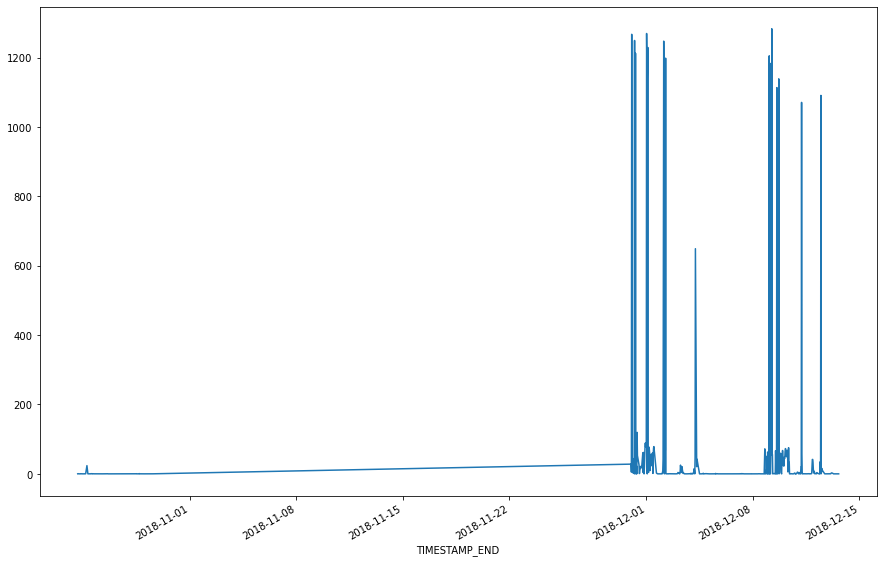

In [18]:
et_data['ET'].plot()

# ET Calc

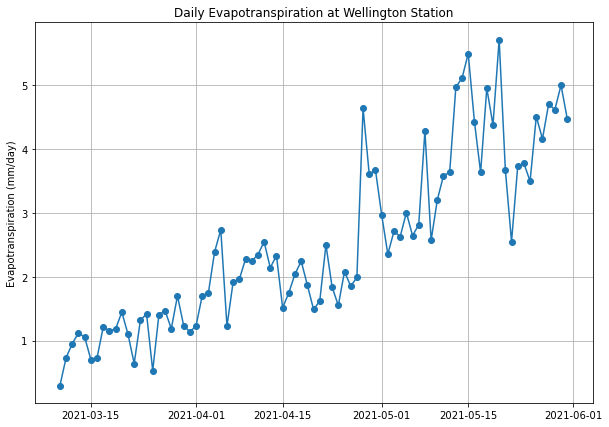

In [9]:
et_data['et'] = et_data[['LE','TA_1_1_1']].apply(lambda x: et_from_le(x[0],time_delta=1,t=x[1]),1)
et_for_exp = et_data.rename(columns = renm)
et_filt = et_data[(et_data['LE_QC']>1)&(et_data['LE']>=0)&(et_data['et']>=0)]
et_filt_int = et_filt.resample('30min').asfreq().interpolate(method='time').resample('1H').mean()
et_dly = et_filt_int.groupby(pd.Grouper(freq='1D')).sum()
et_dly = et_dly[et_dly.index<pd.to_datetime('2021-06-01')]
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(et_dly.index, et_dly['et'],marker='o')
#ax = plt.plot(et_filt.index, et_filt['et'],marker=".")
ax.set_ylabel('Evapotranspiration (mm/day)')
ax.grid()
ax.set_title('Daily Evapotranspiration at Wellington Station')
plt.savefig("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS/et_chart.jpg")

# Plots

## ET

<AxesSubplot:xlabel='TIMESTAMP'>

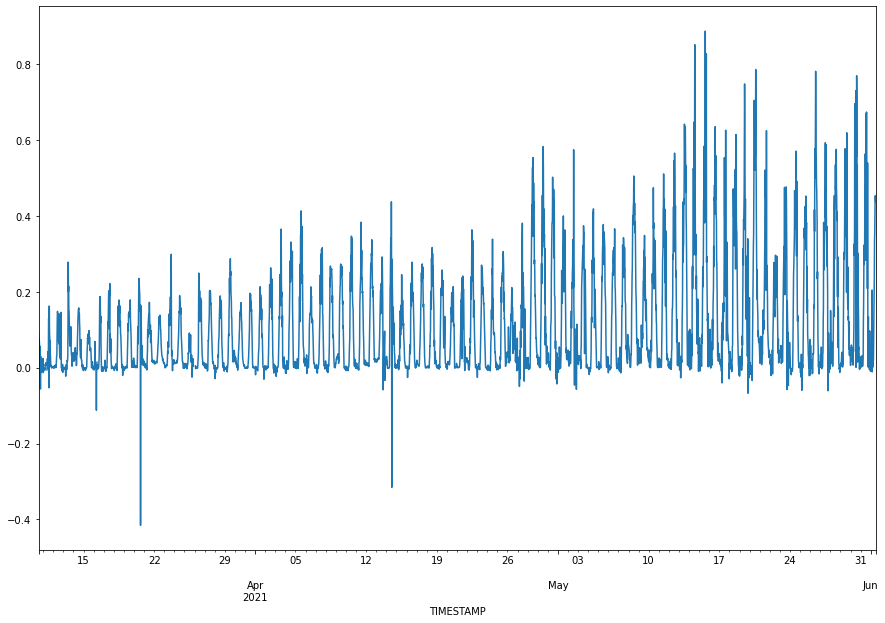

In [10]:
et_data['et'].plot()


## Wind Direction

C:\Users\paulinkenbrandt\.conda\envs\pygis39\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\paulinkenbrandt\.conda\envs\pygis39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


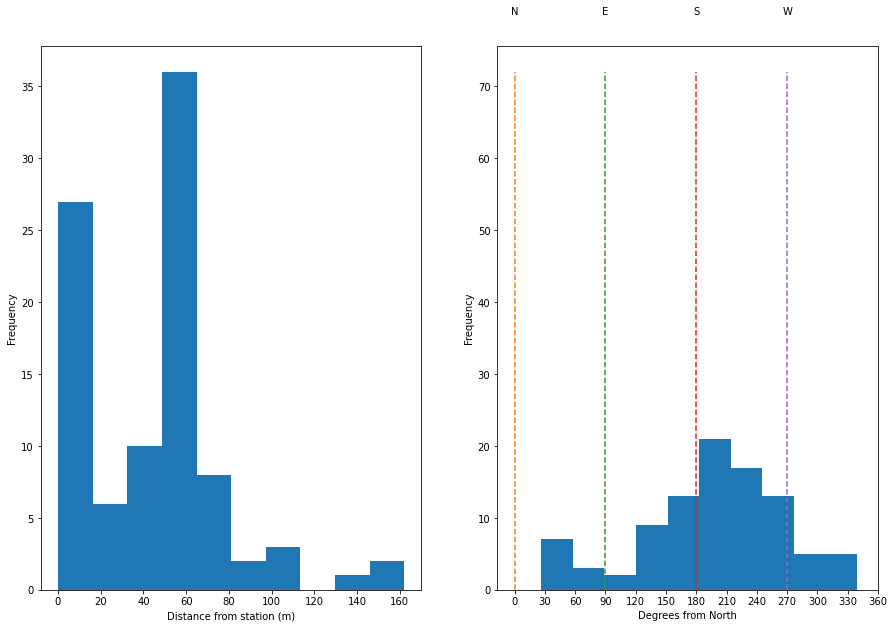

<Figure size 1080x720 with 0 Axes>

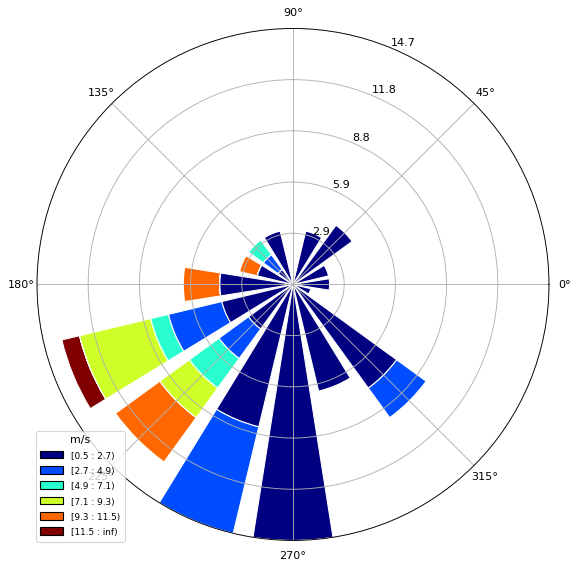

<Figure size 720x720 with 0 Axes>

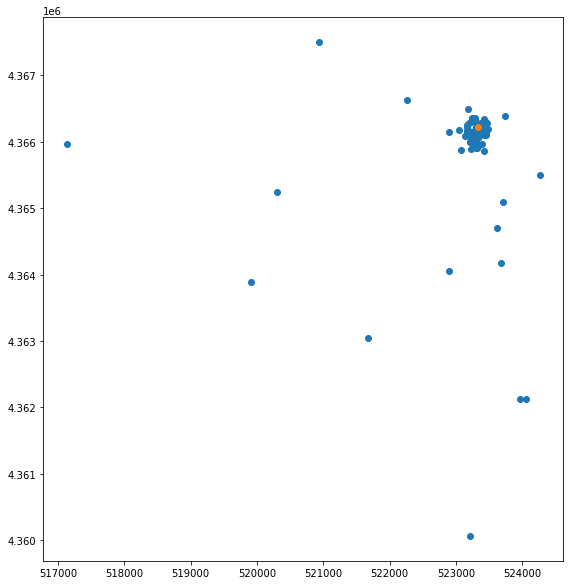

In [11]:
#file_place = "G:/My Drive/WORK/Juab/ET and EddyCovariance/Compilation.xlsx"
#df = pd.read_excel(file_place,'8442_1',header=0,skiprows=[0,2,3])
#df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = et_data[(et_data.index>pd.to_datetime('2021-04-04'))&(et_data.index<pd.to_datetime('2021-04-06'))]

coordins = [523336,4366222]

df.loc[:,'WDadj'] = df['WD'].apply(lambda x: x-360 if x >= 360 else x)

fig, ax = plt.subplots(1,2,figsize=[15,10])
df['FETCH_MAX'].plot(kind='hist',ax=ax[0])
df.loc[:,'WDadj'] = df['WD'].apply(lambda x: x-360 if x >= 360 else x)
df['WDadj'].plot(kind='hist',ax=ax[1])
ax[0].set_xlabel('Distance from station (m)')
#ax[0].set_xscale('log')
ax[1].set_xlabel('Degrees from North')
ax[1].text(0,80,'N', horizontalalignment='center')
ax[1].plot([0,0],[0,72],ls="--")
ax[1].text(90,80,'E', horizontalalignment='center')
ax[1].plot([90,90],[0,72],ls="--")
ax[1].text(180,80,'S', horizontalalignment='center')
ax[1].plot([180,180],[0,72],ls="--")
ax[1].text(270,80,'W', horizontalalignment='center')
ax[1].plot([270,270],[0,72],ls="--")
ax[1].set_xticks(range(0,390,30))
plt.savefig("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS/footprint_bars.jpg")

plt.figure()
ax2 = WindroseAxes.from_ax()
wd = df['WDadj']
ws = df['WS']
ax2.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
ax2.set_legend(title='m/s')
plt.savefig("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS/windrose.jpg")


def coords(x):
    xi = x[1]*np.sin((x[0])*np.pi/180)+coordins[0]
    yi = x[1]*np.cos((x[0])*np.pi/180)+coordins[1]
    return xi,yi


df.loc[:,'coord'] = df[['WDadj','FETCH_90']].apply(lambda x: coords(x),1)
df.loc[:,'x'] = df['coord'].apply(lambda x: x[0],1)
df.loc[:,'y'] = df['coord'].apply(lambda x: x[1],1)

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x,df.y),crs="EPSG:26912")#.to_crs('EPSG:3857')




plt.figure(figsize=(10,10))
#fig, ax = plt.subplots(1,1,figsize=[10,10],)
gdf.plot()
#ax.add_wms(wmts='https://discover.agrc.utah.gov/login/path/nebula-east-focus-virgo/wmts/',
#               layers=['basic'])
#plt.scatter(0,0)
plt.scatter(coordins[0],coordins[1])

gdf = gdf.reset_index().drop(['TIMESTAMP','coord'],axis=1)
gdf.to_file("footprint_fetch_90_20210405.geojson", driver='GeoJSON')
gdf.loc[:,'ETmm'] = gdf['et']*24.

## Net Radiation

<AxesSubplot:xlabel='TIMESTAMP'>

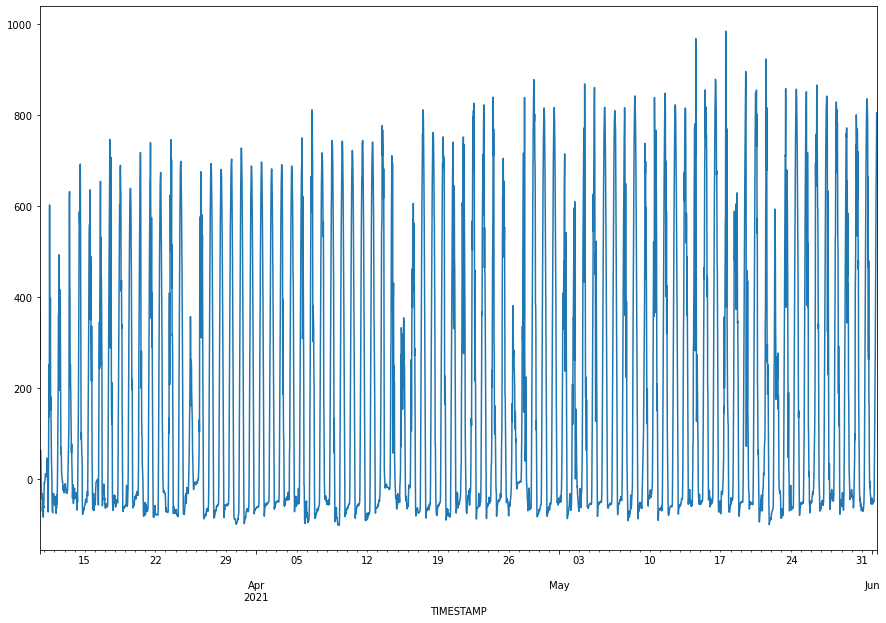

In [12]:
et_data["NETRAD"].plot()

## Temperature

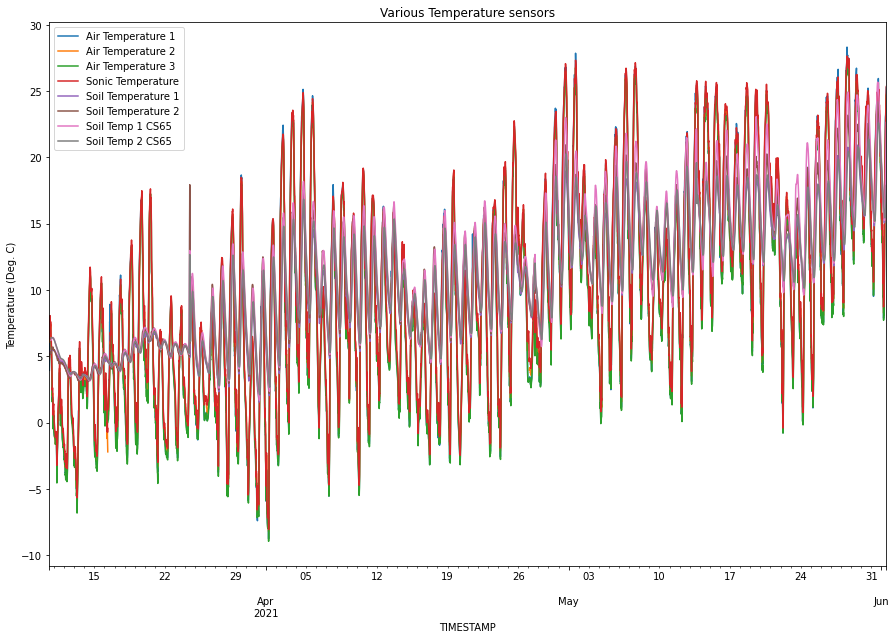

In [13]:
temp_fields = ["TA_1_1_1","TA_2_1_1", "TA_3_1_1", "T_SONIC","TS_1_1_1","TS_2_1_1","TS_CS65X_1_1_1",
               "TS_CS65X_2_1_1"]
et_data[temp_fields].rename(columns=renm).plot()
plt.title('Various Temperature sensors')
plt.ylabel('Temperature (Deg. C)')
plt.savefig("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/Writing and Presentations/figures/temp_comp.jpg")

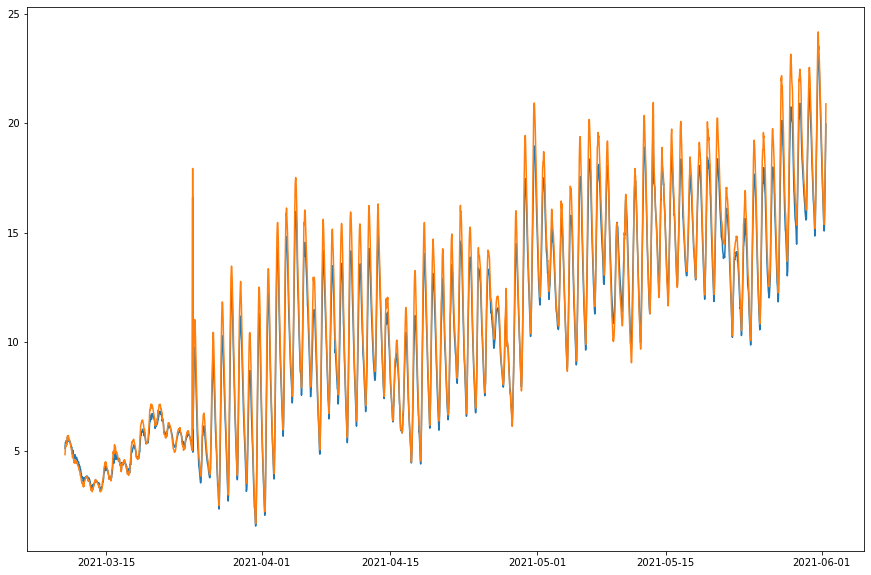

In [14]:
plt.plot(et_data.index, et_data["TS_1_1_1"])
plt.plot(et_data.index,et_data["TS_2_1_1"])

## Heat Flux

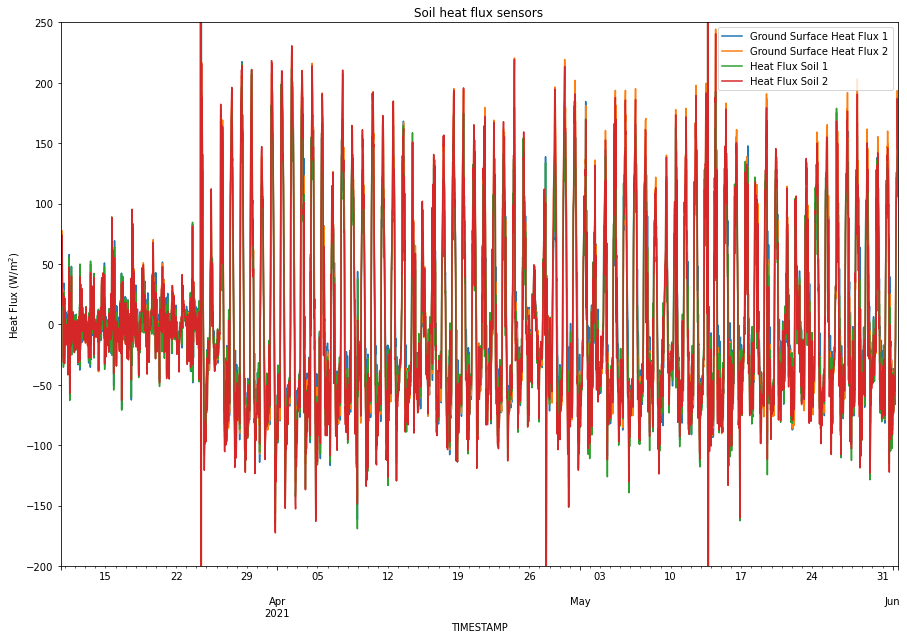

In [15]:

et_data[heat_flux_fields].rename(columns=renm).plot()
plt.ylim(-200,250)
plt.title('Soil heat flux sensors')
plt.ylabel('Heat Flux (W/m$^2$)')
plt.savefig("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/Writing and Presentations/figures/soil_heat_flux_comp.jpg")

## Soil Water Content

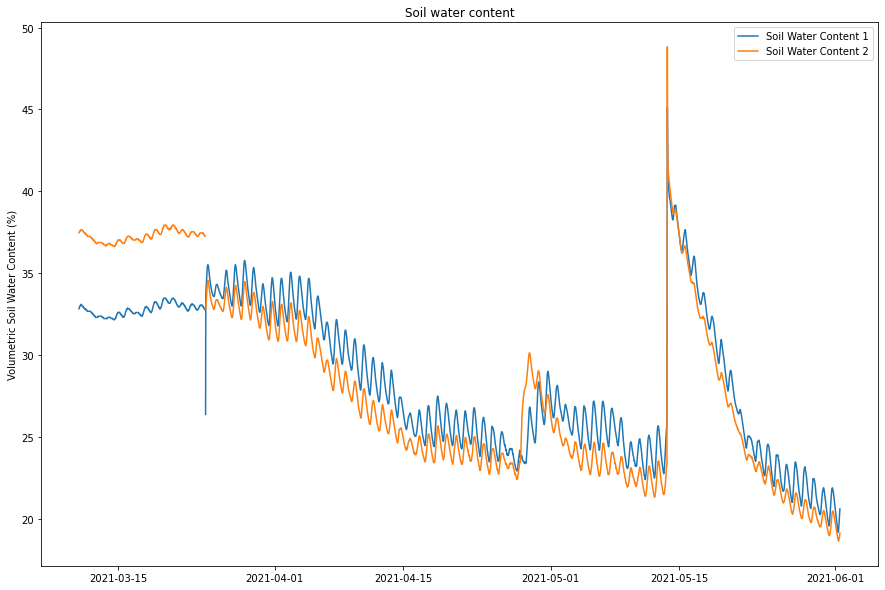

In [16]:
et_data.loc[et_data["SWC_1_1_1"]<17,"SWC_1_1_1"] = None
et_data.loc[et_data["SWC_2_1_1"]<17,"SWC_2_1_1"] = None
plt.plot(et_data.index, et_data["SWC_1_1_1"],label='Soil Water Content 1')
plt.plot(et_data.index,et_data["SWC_2_1_1"],label='Soil Water Content 2')

plt.title('Soil water content')
plt.ylabel('Volumetric Soil Water Content (%)')
plt.legend()
plt.savefig("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/Writing and Presentations/figures/soil_water_content_comp.jpg")

# Save Output

## Save Data for Sharing with Others

In [31]:
et_for_exp = et_for_exp.rename(columns={'et':'evapotranspiration (mm/hr)'})

filename = "G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS/Wellington_output_20210602.xlsx"
with pd.ExcelWriter(filename) as writer:  
    et_for_exp.to_excel(writer, sheet_name='Data')
    descriptors.to_excel(writer, sheet_name='Variable_Descriptions')
    et_dly['et'].to_frame().to_excel(writer, sheet_name='Daily_Summary')
    gdf.to_excel(writer, sheet_name='footprint_points')

## Save Data for Ameriflux

https://ameriflux.lbl.gov/data/aboutdata/data-variables/#qualifiers

https://ameriflux.lbl.gov/half-hourly-hourly-data-upload-format/#format

In [21]:
import pandas as pd
filedir = "G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/Data_Downloads/Wellington/EasyFlux_output/"
etfile = "Wellington_Flux_AmeriFluxFormat.dat"
et_data_am = pd.read_csv(filedir+etfile,skiprows=[0,2,3],index_col='TIMESTAMP',parse_dates=True,na_values='NAN')
et_data_am = et_data_am.resample('30min').asfreq().fillna(value= '-9999').replace('NAN','-9999')
et_data_am['TIMESTAMP_START'] = et_data_am.apply(lambda x: f"{x.name-pd.Timedelta(30, unit='min'):%Y%m%d%H%M}",1).astype('int64')
et_data_am['TIMESTAMP_END'] = et_data_am.apply(lambda x: f"{x.name:%Y%m%d%H%M}",1).astype('int64')
et_data_am = et_data_am.drop(['RECORD','FETCH_55','ET', 'ET_SSITC_TEST', 'FETCH_40', 'U', 'V', 'W',
                             'T_DP_1_1_1', 'T_DP_2_1_1', 'T_DP_3_1_1'],axis=1)
et_data_am.to_csv(filedir + f"US-UTW_HH_{et_data_am.iloc[0,0]}_{et_data_am.iloc[-1,1]}.csv",index=False)

In [19]:
et_data_am.to_clipboard()

In [ ]:
et_data_am['TIMESTAMP_START'] = et_data_am['TIMESTAMP_START'].astype('int64')
et_data_am['TIMESTAMP_END'] = et_data_am['TIMESTAMP_END'].astype('int64')



US-UTW_HH_202107050630_202109221000

<SITE_ID>_<RESOLUTION>_<TS-START>_<TS-END>_<OPTIONAL>.csv

In [36]:
variables = pd.read_csv(filedir+etfile,nrows=1,skiprows=[0,3]).T

In [37]:
variables.loc['FETCH_55']

0    m
Name: FETCH_55, dtype: object

Index(['RECORD', 'TIMESTAMP_START', 'TIMESTAMP_END', 'CO2', 'CO2_SIGMA', 'H2O',
       'H2O_SIGMA', 'FC', 'FC_SSITC_TEST', 'LE', 'LE_SSITC_TEST', 'ET',
       'ET_SSITC_TEST', 'H', 'H_SSITC_TEST', 'G', 'SG', 'FETCH_MAX',
       'FETCH_90', 'FETCH_55', 'FETCH_40', 'WD', 'WS', 'WS_MAX', 'USTAR', 'ZL',
       'TAU', 'TAU_SSITC_TEST', 'MO_LENGTH', 'U', 'U_SIGMA', 'V', 'V_SIGMA',
       'W', 'W_SIGMA', 'PA', 'TA_1_1_1', 'RH_1_1_1', 'T_DP_1_1_1', 'TA_2_1_1',
       'RH_2_1_1', 'T_DP_2_1_1', 'TA_3_1_1', 'RH_3_1_1', 'T_DP_3_1_1', 'VPD',
       'T_SONIC', 'T_SONIC_SIGMA', 'PBLH', 'TS_1_1_1', 'TS_2_1_1', 'SWC_1_1_1',
       'SWC_2_1_1', 'ALB', 'NETRAD', 'SW_IN', 'SW_OUT', 'LW_IN', 'LW_OUT',
       'P'],
      dtype='object')

Const PATH_LENGTH_CSAT = 0.1154701       'CSAT path length = 10 cm/sin(pi/3) (m)

Public sonic(5)                          'Hold CSAT data aligned in scan with data from IRGA and/or fine wire thermocouple
Alias  sonic(1) = Ts
Alias  sonic(2) = Ux
Alias  sonic(3) = Uy
Alias  sonic(4) = Uz
Alias  sonic(5) = diag_sonic

In [ ]:
#      'Compute the molar mixing ratio of CO2 and H2O.
divisor = (amb_press/(R*Tc_K))-(H2O_density/18.01528)
CO2_mixratio = CO2_density/(0.04401*divisor)
H2O_mixratio = H2O_density/(0.01802*divisor)

divisor = (amb_press/(R*(amb_tmpr + 273.15)))-(H2O_density/18.01528)                       #'For CR1000KD display
CO2_mixratio_kd = CO2_density/(0.04401*divisor)
H2O_mixratio_kd = H2O_density/(0.01802*divisor)


In [39]:
R = 8.3143e-3  #Universal gas constant [kPa m^3/(K mol)]
Rd = R/28.97   #Gas constant for dry air [kPa m^3/(K g)]
Rv = R/18.016  #Gas constant for water vapor [kPa m^3/(K g)]

Ts_K =  #Sonic temperature in K

# See "An approach of total differental to derivation for the correction equation of air temperature flux from sonic temperature flux", 
# equation 28, v2 (Aug 3, 2015) by Zhou et al.(unpublished)
if irga_bad_data:
    T_tmp= (2*Ts_K*dly_data_out(5))/(dly_data_out(5) + np.sqrt(dly_data_out(5)*(dly_data_out(5) +1.28*Rv*dly_data_out(2)*Ts_K))) 
else:
    T_tmp = dly_data_out(4) + T_0C_K


# Compute the molar number of dry air in m^3
divisor = (dly_data_out(5)/(R*T_tmp))-(dly_data_out(2)/18.01528)

CO2_umolmol = CO2_density/(0.04401*divisor)              'CO2_density in mg m-3 to CO2 in umol mol-1 (See http://www.carbontracker.eu/glossary.html)

Move (cov_array_H2O(array_index, 1), 1, dly_data_out(2),1)                           'H2O_density in g m-3
Move (cov_array_H2O(array_index, 2), 3, Ux, 3)
H2O_bad_rng_sig_array (array_index) = ((dly_data_out(7) < H2O_SIG_STRGTH_THRESHOLD) OR (dly_data_out(2) <0) OR (dly_data_out(2) > H2O_RNG_TOP_LIMIT))
cov_array_H2O(array_index, 5)       = dly_data_out(2)/(0.01801582*divisor)              'H2O in mmol mol-1 (See http://www.carbontracker.eu/glossary.html)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [22]:
et_data.columns

Index(['RECORD', 'FC_mass', 'FC_QC', 'FC_samples', 'LE', 'LE_QC', 'LE_samples',
       'H', 'H_QC', 'H_samples', 'NETRAD', 'G', 'SG', 'energy_closure',
       'poor_enrg_clsur', 'Bowen_ratio', 'TAU', 'TAU_QC', 'USTAR', 'TSTAR',
       'TKE', 'TA_1_1_1', 'RH_1_1_1', 'T_DP_1_1_1', 'amb_e', 'amb_e_sat',
       'TA_2_1_1', 'RH_2_1_1', 'T_DP_2_1_1', 'e', 'e_sat', 'TA_3_1_1',
       'RH_3_1_1', 'T_DP_3_1_1', 'e_probe', 'e_sat_probe', 'H2O_probe', 'PA',
       'VPD', 'Ux', 'Ux_SIGMA', 'Uy', 'Uy_SIGMA', 'Uz', 'Uz_SIGMA', 'T_SONIC',
       'T_SONIC_SIGMA', 'sonic_azimuth', 'WS', 'WS_RSLT', 'WD_SONIC',
       'WD_SIGMA', 'WD', 'WS_MAX', 'CO2_density', 'CO2_density_SIGMA',
       'H2O_density', 'H2O_density_SIGMA', 'CO2_sig_strgth_Min',
       'H2O_sig_strgth_Min', 'P', 'ALB', 'SW_IN', 'SW_OUT', 'LW_IN', 'LW_OUT',
       'T_nr', 'R_LW_in_meas', 'R_LW_out_meas', 'sun_azimuth', 'sun_elevation',
       'hour_angle', 'sun_declination', 'air_mass_coeff', 'daytime',
       'TS_1_1_1', 'TS_2_1_1', 'SWC_